Copyright 2025 Marc Kamionkowski and Kris Sigurdson.
Licensed under Apache-2.0 (http://www.apache.org/licenses/LICENSE-2.0).

This notebook demonstrates visualization and analysis of anisotropic velocity distributions in self-interacting dark matter halos. It reproduces all figures from the paper "Gravothermal collapse of self-interacting dark-matter halos with anisotropic velocity distributions."

You must have successfully installed NSphere by following the instructions in the main [README](https://github.com/kris-sigurdson/NSphere). Ensure the `nsphere` Python virtual environment is activated (`source ./activate_nsphere` from the project root).

This Jupyter notebook is set up to be run from the `NSphere-SIDM/examples` subdirectory.

### Anisotropic SIDM Halo Analysis

## Data Generation Commands

This notebook requires simulation data generated with the following commands from the `NSphere-SIDM` directory:

**Constant-β models** (5 runs for **Figure 1**, **Figure 2**):
```bash
# Beta = 0 (isotropic)
./nsphere \
  --ntimesteps   6250001 \
  --nout         250 \
  --dtwrite      25000 \
  --tfinal       300 \
  --profile      hernquist \
  --scale-radius 1.18 \
  --halo-mass    2.818e8 \
  --sort         6 \
  --master-seed  42 \
  --sidm \
  --tag          beta0.0

# Beta = 0.5 (radial)
./nsphere \
  --ntimesteps   6250001 \
  --nout         250 \
  --dtwrite      25000 \
  --tfinal       300 \
  --profile      hernquist \
  --scale-radius 1.18 \
  --halo-mass    2.818e8 \
  --sort         6 \
  --master-seed  42 \
  --sidm \
  --tag          beta0.5 \
  --aniso-beta   0.5
```

Additional runs use `--aniso-beta -0.5` (tag `beta-0.5`), `--aniso-beta -0.25` (tag `beta-0.25`), and `--aniso-beta 0.25` (tag `beta0.25`) with the same parameters.

**Osipkov-Merritt models** (11 runs for **Figure 3**):
```bash
# Example: Beta(r_s) = 0.25 (extended run)
./nsphere \
  --ntimesteps      9375001 \
  --nout            375 \
  --dtwrite         25000 \
  --tfinal          450 \
  --profile         hernquist \
  --scale-radius    1.18 \
  --halo-mass       2.818e8 \
  --sort            6 \
  --master-seed     42 \
  --sidm \
  --tag             betascale0.25 \
  --aniso-betascale 0.25
```

Additional runs with `--aniso-betascale`: 0.05, 0.10, 0.15, 0.175, 0.40, 0.50, 0.60, 0.70 use the same extended parameters with corresponding tags. The isotropic run and β(r_s)=0.80 use standard parameters (tfinal=300, nout=250, ntimesteps=6250001).

**Figure 4** requires no simulation data (analytical calculations only).

For more information on NSphere, see the [full documentation](https://kris-sigurdson.github.io/NSphere/).

## Figure 1: Initial Phase-Space Distributions for Different β Values

This cell creates the 3-panel phase-space comparison showing how the initial radial velocity distribution changes with anisotropy parameter β.

Saved: pdf/fig1.pdf


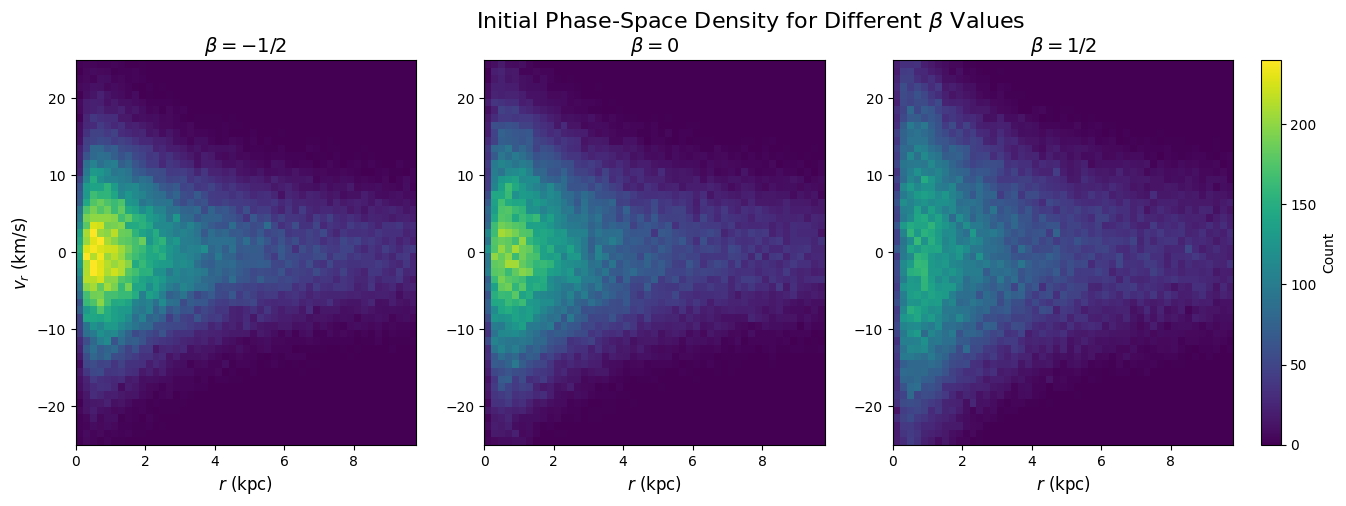

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.integrate import quad
import os

# Define the record dtype for binary data files
record_dtype = np.dtype([
    ('rank',  np.int32),
    ('mass',  np.float32),
    ('R',     np.float32),
    ('Vrad',  np.float32),
    ('PsiA',  np.float32),
    ('E',     np.float32),
    ('L',     np.float32)
])

# Define the paths to initial condition files for each beta value
paths = {
    r'$\beta=-1/2$': "../data/Rank_Mass_Rad_VRad_unsorted_t00000_beta-0.5_100000_6250001_300.dat",
    r'$\beta=0$': "../data/Rank_Mass_Rad_VRad_unsorted_t00000_beta0.0_100000_6250001_300.dat",
    r'$\beta=1/2$': "../data/Rank_Mass_Rad_VRad_unsorted_t00000_beta0.5_100000_6250001_300.dat"
}

# Define bin edges for radius (R) and radial velocity (Vrad)
bin_edges_R = np.arange(0, 10, 0.2)      # 0 to 10 kpc in steps of 0.2
bin_edges_V = np.arange(-50, 50, 1)      # -50 to 50 km/s in steps of 1

# Storage for histograms
histograms = {}

# Process each file
for label, file_path in paths.items():
    try:
        alldata = np.fromfile(file_path, dtype=record_dtype)
        data_R = alldata['R']
        data_Vrad = alldata['Vrad'] / 1.023e-3  # Convert to km/s
        
        # Compute 2D histogram
        hist, _, _ = np.histogram2d(data_R, data_Vrad, bins=[bin_edges_R, bin_edges_V])
        smoothed_hist = gaussian_filter(hist, sigma=(0.1, 0.1))
        histograms[label] = smoothed_hist
        
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        histograms[label] = np.zeros((len(bin_edges_R)-1, len(bin_edges_V)-1))

# Create the 3-panel figure
vmax = 240  # Match paper scale
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (label, hist) in enumerate(histograms.items()):
    ax = axes[idx]
    im = ax.imshow(hist.T, origin='lower',
                   extent=[bin_edges_R[0], bin_edges_R[-1], bin_edges_V[0], bin_edges_V[-1]],
                   aspect='auto', cmap='viridis', vmin=0, vmax=vmax)
    
    ax.set_xlabel(r"$r$ (kpc)", fontsize=12)
    if idx == 0:
        ax.set_ylabel(r"$v_r$ (km/s)", fontsize=12)
    ax.set_title(label, fontsize=14)
    ax.set_ylim([-25, 25])

# Add title and colorbar BEFORE tight_layout
fig.suptitle(r"Initial Phase-Space Density for Different $\beta$ Values", fontsize=16, y=0.98)
fig.colorbar(im, ax=axes.ravel().tolist(), label="Count", pad=0.02)

# Save Figure 1 as PDF (matching paper figure)
# This generates pdf/fig1.pdf - the initial phase-space density plot
# Comment out the lines below if you only want to view the figure without saving
os.makedirs("pdf", exist_ok=True)
plt.savefig("pdf/fig1.pdf", dpi=300, bbox_inches='tight')
print('Saved: pdf/fig1.pdf')

plt.show()

## Figures 2a, 2b, 2c: Evolution Analysis for 5 Constant-β Models

This cell analyzes the time evolution of:
- **Fig 2a**: Particle count in innermost 0.02 kpc
- **Fig 2b**: Velocity dispersion in inner 0.2 kpc
- **Fig 2c**: Anisotropy parameter β evolution

In [2]:
from scipy.ndimage import gaussian_filter1d
import numpy as np
import os

record_dtype = np.dtype([
    ('rank',  np.int32),
    ('mass',  np.float32),
    ('R',     np.float32),
    ('Vrad',  np.float32),
    ('PsiA',  np.float32),
    ('E',     np.float32),
    ('L',     np.float32)
])

# Define the five beta configurations
beta_configs = {
    r'$\beta=-1/2$': {
        'path_template': "../data/Rank_Mass_Rad_VRad_unsorted_t00{timestep:03d}_beta-0.5_100000_6250001_300.dat",
        'color': 'blue', 'linestyle': '-'
    },
    r'$\beta=-1/4$': {
        'path_template': "../data/Rank_Mass_Rad_VRad_unsorted_t00{timestep:03d}_beta-0.25_100000_6250001_300.dat",
        'color': 'purple', 'linestyle': ':'
    },
    r'$\beta=0$': {
        'path_template': "../data/Rank_Mass_Rad_VRad_unsorted_t00{timestep:03d}_beta0.0_100000_6250001_300.dat",
        'color': 'green', 'linestyle': '--'
    },
    r'$\beta=1/4$': {
        'path_template': "../data/Rank_Mass_Rad_VRad_unsorted_t00{timestep:03d}_beta0.25_100000_6250001_300.dat",
        'color': 'violet', 'linestyle': '-.'
    },
    r'$\beta=1/2$': {
        'path_template': "../data/Rank_Mass_Rad_VRad_unsorted_t00{timestep:03d}_beta0.5_100000_6250001_300.dat",
        'color': 'red', 'linestyle': ':'
    }
}

time_steps = range(0, 250, 1)
bin_edges = np.arange(0, 2, 0.02)
results = {}
threshold_particles = None

# Process each beta configuration
for beta_label, config in beta_configs.items():
    print(f"Processing {beta_label}...")
    
    lowest_bin_counts = []
    msv_bins1_n_list = []
    beta_bins1_n_list = []
    actual_time_steps = []
    
    for time_step in time_steps:
        file_path = config['path_template'].format(timestep=time_step)
        try:
            if not os.path.exists(file_path):
                continue
                
            alldata = np.fromfile(file_path, dtype=record_dtype)
            
            if threshold_particles is None and alldata.size > 0:
                threshold_particles = alldata.size / 1000
                print(f"  0.1% threshold = {threshold_particles:.1f} particles (N={alldata.size})")
            
            if alldata.size == 0:
                continue
                
            radii = alldata['R']
            vrad = alldata['Vrad']
            L = alldata['L']
            
            # Calculate tangential velocity
            with np.errstate(divide='ignore', invalid='ignore'):
                vtangential = np.where(radii > 1e-6, L / radii, 0.0)
            
            # Filter for valid particles
            valid_mask = (np.isfinite(radii) & np.isfinite(vrad) & 
                         np.isfinite(vtangential) & (radii > 1e-6))
            
            if not np.any(valid_mask):
                continue
            
            radii = radii[valid_mask]
            vrad = vrad[valid_mask]
            vtangential = vtangential[valid_mask]
            
            # Histogram and smoothing
            counts, _ = np.histogram(radii, bins=bin_edges)
            smoothed_counts = gaussian_filter1d(counts, sigma=0.001)
            lowest_bin_counts.append(smoothed_counts[0])
            
            # Velocity dispersion for inner bins
            bin_indices = np.digitize(radii, bin_edges, right=False)
            mask_bins1_n = (bin_indices >= 1) & (bin_indices <= 10)
            vrad_bins1_n = vrad[mask_bins1_n]
            vtangential_bins1_n = vtangential[mask_bins1_n]
            
            if len(vrad_bins1_n) > 10:
                mean_vr2 = np.mean(vrad_bins1_n**2) / (1.023e-3**2)
                mean_vtan2 = np.mean(vtangential_bins1_n**2) / (1.023e-3**2)
                msv_bins1_n = mean_vr2 + mean_vtan2
                
                # Calculate beta
                if mean_vr2 > 1e-10:
                    beta_bins1_n = 1.0 - mean_vtan2 / (2.0 * mean_vr2)
                    beta_bins1_n = np.clip(beta_bins1_n, -1.0, 1.0)
                else:
                    beta_bins1_n = np.nan
            else:
                msv_bins1_n = np.nan
                beta_bins1_n = np.nan
                
            msv_bins1_n_list.append(msv_bins1_n)
            beta_bins1_n_list.append(beta_bins1_n)
            actual_time_steps.append(time_step)
            
        except Exception as e:
            continue
    
    # Convert to Gyr
    actual_time_steps_gyr = 10.801 / 250 * np.array(actual_time_steps)
    lowest_bin_counts_array = np.array(lowest_bin_counts)
    
    # Find peak
    if len(lowest_bin_counts_array) > 0:
        max_idx = np.argmax(lowest_bin_counts_array)
    else:
        max_idx = 0
    
    results[beta_label] = {
        'time': actual_time_steps_gyr[:max_idx+1],
        'time_full': actual_time_steps_gyr,
        'lowest_bin_counts': lowest_bin_counts_array[:max_idx+1],
        'lowest_bin_counts_full': lowest_bin_counts_array,
        'msv_bins1_n': np.array(msv_bins1_n_list)[:max_idx+1],
        'beta_bins1_n': np.array(beta_bins1_n_list),
        'color': config['color'],
        'linestyle': config['linestyle']
    }

print(f"\nProcessed {len(results)} runs")

Processing $\beta=-1/2$...
  0.1% threshold = 100.0 particles (N=100000)
Processing $\beta=-1/4$...
Processing $\beta=0$...
Processing $\beta=1/4$...
Processing $\beta=1/2$...

Processed 5 runs


Saved: pdf/fig2a.pdf


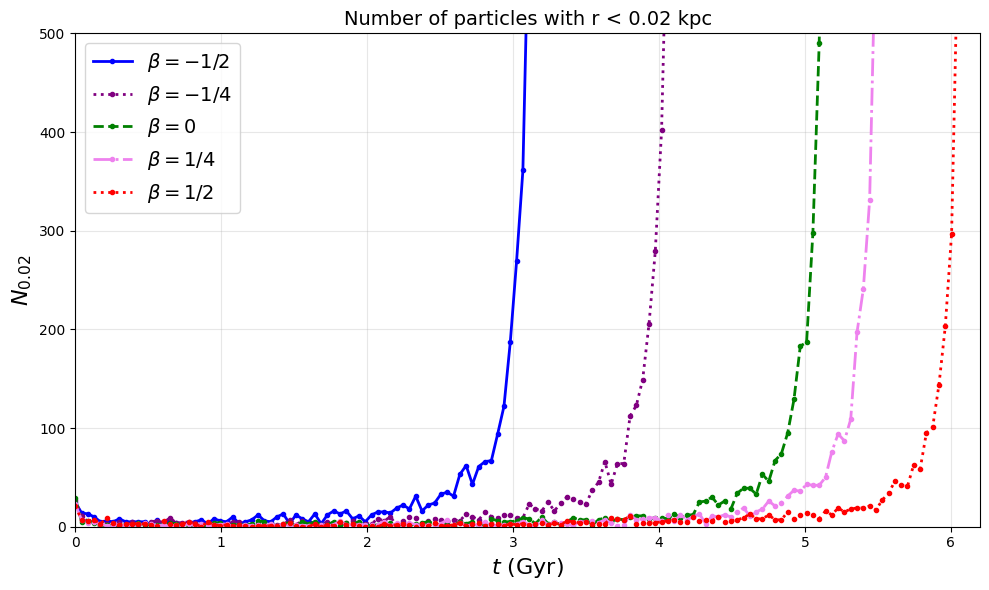

In [3]:
# Figure 2a: Particle count evolution
fig2a, ax2a = plt.subplots(figsize=(10, 6))
for beta_label, data in results.items():
    ax2a.plot(data['time'], data['lowest_bin_counts'], 
             marker='.', linestyle=data['linestyle'], color=data['color'], 
             label=beta_label, linewidth=2)

ax2a.set_xlabel(r"$t$ (Gyr)", fontsize=16)
ax2a.set_ylabel(r"$N_{0.02}$", fontsize=16)
ax2a.set_title("Number of particles with r < 0.02 kpc", fontsize=14)
ax2a.legend(fontsize=14, loc='best')
ax2a.set_xlim(0, 6.2)
ax2a.set_ylim(0, 500)
ax2a.grid(True, alpha=0.3)
plt.tight_layout()

# Save Figure 2a as PDF (matching paper figure)
# This generates pdf/fig2a.pdf - particle count evolution in central 0.02 kpc
# Comment out the lines below if you only want to view the figure without saving
os.makedirs("pdf", exist_ok=True)
plt.savefig("pdf/fig2a.pdf", dpi=300, bbox_inches='tight')
print('Saved: pdf/fig2a.pdf')

plt.show()

Saved: pdf/fig2b.pdf


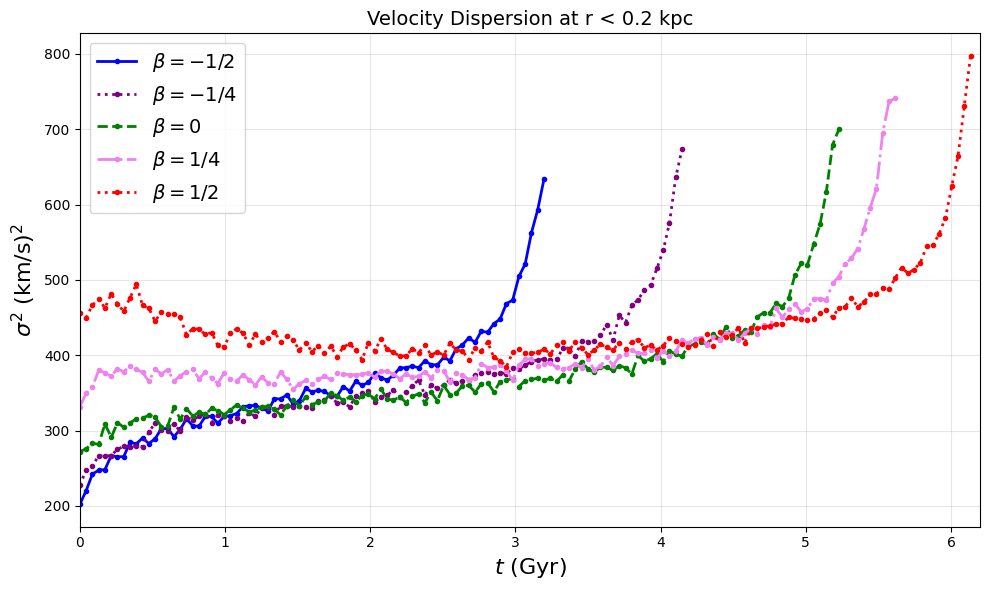

In [4]:
# Figure 2b: Velocity dispersion evolution - truncate at σ² peak
fig2b, ax2b = plt.subplots(figsize=(10, 6))
for beta_label, data in results.items():
    valid_msv = ~np.isnan(data['msv_bins1_n'])
    if np.any(valid_msv):
        msv_peak_idx = np.argmax(data['msv_bins1_n'][valid_msv])
        ax2b.plot(data['time'][valid_msv][:msv_peak_idx+1], 
                 data['msv_bins1_n'][valid_msv][:msv_peak_idx+1], 
                 marker='.', linestyle=data['linestyle'], color=data['color'], 
                 label=beta_label, linewidth=2)

ax2b.set_xlabel(r"$t$ (Gyr)", fontsize=16)
ax2b.set_ylabel(r'$\sigma^2$ (km/s)$^2$', fontsize=16)
ax2b.set_title("Velocity Dispersion at r < 0.2 kpc", fontsize=14)
ax2b.legend(fontsize=14, loc='best')
ax2b.set_xlim(0, 6.2)
ax2b.grid(True, alpha=0.3)
plt.tight_layout()

# Save Figure 2b as PDF (matching paper figure)
# This generates pdf/fig2b.pdf - velocity dispersion evolution in central 0.2 kpc
# Each curve truncated at its σ² peak to avoid post-collapse artifacts
# Comment out the lines below if you only want to view the figure without saving
os.makedirs("pdf", exist_ok=True)
plt.savefig("pdf/fig2b.pdf", dpi=300, bbox_inches='tight')
print('Saved: pdf/fig2b.pdf')

plt.show()

Saved: pdf/fig2c.pdf


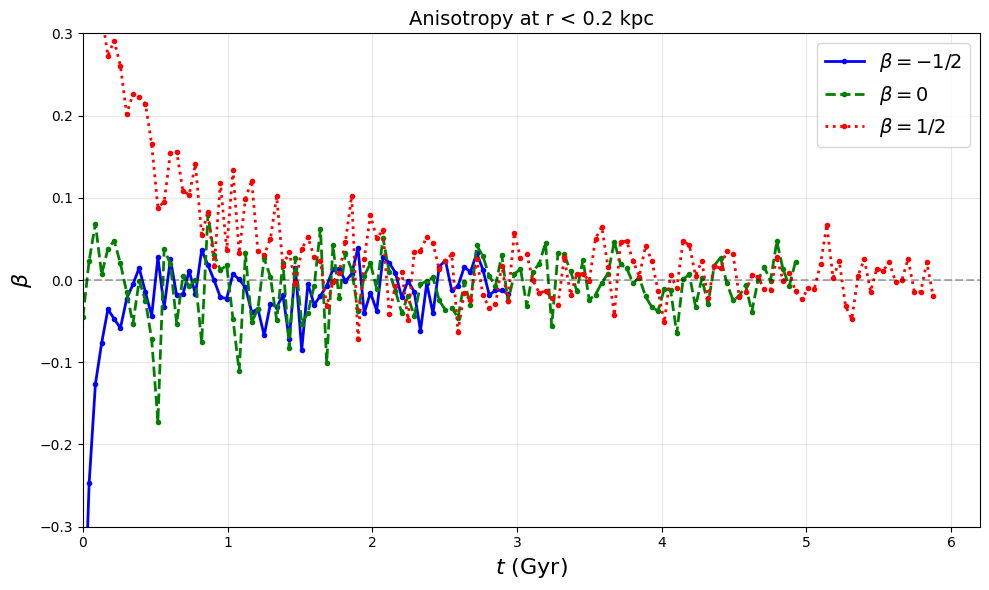

In [5]:
# Figure 2c: Beta evolution - truncate at 0.1% threshold (collapse time)
fig2c, ax2c = plt.subplots(figsize=(10, 6))

paper_betas = [r'$\beta=-1/2$', r'$\beta=0$', r'$\beta=1/2$']

for beta_label, data in results.items():
    if beta_label in paper_betas:
        full_counts = data.get('lowest_bin_counts_full', [])
        time_full = np.array(data['time_full'])
        
        if len(full_counts) > 0 and len(time_full) > 0:
            threshold_mask = full_counts >= threshold_particles
            if np.any(threshold_mask):
                threshold_idx = np.argmax(threshold_mask)
                collapse_time = time_full[threshold_idx]
            else:
                collapse_time = time_full[-1]
        elif len(data['time']) > 0:
            collapse_time = data['time'][-1]
        else:
            continue
        
        valid_beta = ~np.isnan(data['beta_bins1_n'])
        time_mask = time_full <= collapse_time
        combined_mask = valid_beta & time_mask
        
        ax2c.plot(time_full[combined_mask], data['beta_bins1_n'][combined_mask], 
                 marker='.', linestyle=data['linestyle'], color=data['color'], 
                 label=beta_label, linewidth=2)

ax2c.set_xlabel(r"$t$ (Gyr)", fontsize=16)
ax2c.set_ylabel(r'$\beta$', fontsize=16)
ax2c.set_title("Anisotropy at r < 0.2 kpc", fontsize=14)
ax2c.legend(fontsize=14, loc='best')
ax2c.set_xlim(0, 6.2)
ax2c.set_ylim(-0.3, 0.3)
ax2c.grid(True, alpha=0.3)
ax2c.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.tight_layout()

# Save Figure 2c as PDF (matching paper figure)
# This generates pdf/fig2c.pdf - anisotropy β evolution for 3 representative runs
# Each curve truncated at 0.1% threshold (when 100 particles enter r < 0.02 kpc)
# Comment out the lines below if you only want to view the figure without saving
os.makedirs("pdf", exist_ok=True)
plt.savefig("pdf/fig2c.pdf", dpi=300, bbox_inches='tight')
print('Saved: pdf/fig2c.pdf')

plt.show()

## Figures 3a, 3b: Osipkov-Merritt Model Analysis

Analyzes 11 Osipkov-Merritt models (isotropic plus 10 anisotropic configurations with β(r_s) from 0.05 to 0.80). Most models use extended runs (ntimesteps=9375001, nout=375, tfinal=450). The isotropic and β(r_s)=0.80 models use standard parameters (ntimesteps=6250001, nout=250, tfinal=300).

These cells create:
- **Fig 3a**: Central velocity dispersion evolution for all OM models
- **Fig 3b**: Core collapse time vs anisotropy parameter β(r_s)

In [6]:
# Process OM models - ALL timesteps for each model

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import os
import re

kmsec_to_kpcmyr = 1.02271e-3

record_dtype = np.dtype([
    ('rank',  np.int32),
    ('mass',  np.float32),
    ('R',     np.float32),
    ('Vrad',  np.float32),
    ('PsiA',  np.float32),
    ('E',     np.float32),
    ('L',     np.float32)
])

om_configs = {
    r'Isotropic ($\beta=0$)': {
        'path_template': "../data/Rank_Mass_Rad_VRad_unsorted_t00{timestep:03d}_100000_6250001_300.dat",
        'max_t': 250, 'time_factor': 10.801/250,
        'color': 'black', 'linestyle': '-', 'linewidth': 2.5, 'is_om': False
    },
    r'$\beta(r_s)=0.05$': {
        'path_template': "../data/Rank_Mass_Rad_VRad_unsorted_t00{timestep:03d}_betascale0.05_100000_9375001_450.dat",
        'max_t': 375, 'time_factor': 16.2/375,
        'color': 'blue', 'linestyle': '-', 'linewidth': 2, 'is_om': True
    },
    r'$\beta(r_s)=0.10$': {
        'path_template': "../data/Rank_Mass_Rad_VRad_unsorted_t00{timestep:03d}_betascale0.1_100000_9375001_450.dat",
        'max_t': 375, 'time_factor': 16.2/375,
        'color': 'green', 'linestyle': '--', 'linewidth': 2, 'is_om': True
    },
    r'$\beta(r_s)=0.15$': {
        'path_template': "../data/Rank_Mass_Rad_VRad_unsorted_t00{timestep:03d}_betascale0.15_100000_9375001_450.dat",
        'max_t': 375, 'time_factor': 16.2/375,
        'color': 'cyan', 'linestyle': '-.', 'linewidth': 2, 'is_om': True
    },
    r'$\beta(r_s)=0.175$': {
        'path_template': "../data/Rank_Mass_Rad_VRad_unsorted_t00{timestep:03d}_betascale0.175_100000_9375001_450.dat",
        'max_t': 375, 'time_factor': 16.2/375,
        'color': 'teal', 'linestyle': ':', 'linewidth': 2, 'is_om': True
    },
    r'$\beta(r_s)=0.25$': {
        'path_template': "../data/Rank_Mass_Rad_VRad_unsorted_t00{timestep:03d}_betascale0.25_100000_9375001_450.dat",
        'max_t': 375, 'time_factor': 16.2/375,
        'color': 'goldenrod', 'linestyle': '-', 'linewidth': 2, 'is_om': True
    },
    r'$\beta(r_s)=0.40$': {
        'path_template': "../data/Rank_Mass_Rad_VRad_unsorted_t00{timestep:03d}_betascale0.4_100000_9375001_450.dat",
        'max_t': 375, 'time_factor': 16.2/375,
        'color': 'red', 'linestyle': '-.', 'linewidth': 2, 'is_om': True
    },
    r'$\beta(r_s)=0.50$': {
        'path_template': "../data/Rank_Mass_Rad_VRad_unsorted_t00{timestep:03d}_betascale0.5_100000_9375001_450.dat",
        'max_t': 375, 'time_factor': 16.2/375,
        'color': 'brown', 'linestyle': '-', 'linewidth': 2, 'is_om': True
    },
    r'$\beta(r_s)=0.60$': {
        'path_template': "../data/Rank_Mass_Rad_VRad_unsorted_t00{timestep:03d}_betascale0.6_100000_9375001_450.dat",
        'max_t': 375, 'time_factor': 16.2/375,
        'color': 'magenta', 'linestyle': ':', 'linewidth': 2, 'is_om': True
    },
    r'$\beta(r_s)=0.70$': {
        'path_template': "../data/Rank_Mass_Rad_VRad_unsorted_t00{timestep:03d}_betascale0.7_100000_9375001_450.dat",
        'max_t': 375, 'time_factor': 16.2/375,
        'color': 'olive', 'linestyle': '--', 'linewidth': 2, 'is_om': True
    },
    r'$\beta(r_s)=0.80$': {
        'path_template': "../data/Rank_Mass_Rad_VRad_unsorted_t00{timestep:03d}_betascale0.8_100000_6250001_300.dat",
        'max_t': 250, 'time_factor': 10.801/250,
        'color': 'darkred', 'linestyle': '-', 'linewidth': 2, 'is_om': True
    }
}

bin_edges = np.arange(0, 2, 0.02)
results_om = {}
threshold_particles = None

for run_label, config in om_configs.items():
    print(f"Processing {run_label}...")
    
    lowest_bin_counts = []
    msv_bins1_n_list = []
    actual_times = []
    
    for t in range(0, config['max_t'] + 1):
        try:
            fpath = config['path_template'].format(timestep=t)
            if not os.path.exists(fpath):
                continue
            
            data = np.fromfile(fpath, dtype=record_dtype)
            
            if threshold_particles is None and data.size > 0:
                threshold_particles = data.size / 1000
                print(f"  0.1% threshold = {threshold_particles:.1f} particles")
            
            if data.size == 0:
                continue
            
            radii = data['R']
            vrad = data['Vrad']
            
            valid = np.isfinite(radii) & np.isfinite(vrad) & (radii > 1e-6)
            radii = radii[valid]
            vrad = vrad[valid]
            
            counts, _ = np.histogram(radii, bins=bin_edges)
            smoothed = gaussian_filter1d(counts, sigma=0.001)
            lowest_bin_counts.append(smoothed[0])
            
            bin_indices = np.digitize(radii, bin_edges, right=False)
            mask = (bin_indices >= 1) & (bin_indices <= 10)
            vrad_inner = vrad[mask]
            
            if len(vrad_inner) > 10:
                msv = 3.0 * np.mean(vrad_inner**2) / (1.023e-3**2)
            else:
                msv = np.nan
            
            msv_bins1_n_list.append(msv)
            actual_times.append(t * config['time_factor'])
            
        except:
            continue
    
    print(f"  Processed {len(actual_times)} timesteps")
    
    results_om[run_label] = {
        'time': np.array(actual_times),
        'msv_bins1_n': np.array(msv_bins1_n_list),
        'lowest_bin_counts_full': np.array(lowest_bin_counts),
        'color': config['color'],
        'linestyle': config['linestyle'],
        'linewidth': config['linewidth'],
        'is_om': config['is_om']
    }

# Calculate threshold times
om_threshold_data = []

for run_label, data in results_om.items():
    if data['is_om']:
        match = re.search(r'beta\(r_s\)=([0-9.]+)', run_label)
        if match:
            beta_s = float(match.group(1))
            counts = data['lowest_bin_counts_full']
            times = data['time']
            threshold_mask = counts >= threshold_particles
            if np.any(threshold_mask):
                om_threshold_data.append({
                    'beta_s': beta_s,
                    't_0.1%': times[np.argmax(threshold_mask)],
                    'color': data['color']
                })

for run_label, data in results_om.items():
    if not data['is_om']:
        counts = data['lowest_bin_counts_full']
        times = data['time']
        threshold_mask = counts >= threshold_particles
        if np.any(threshold_mask):
            om_threshold_data.append({
                'beta_s': 0.0,
                't_0.1%': times[np.argmax(threshold_mask)],
                'color': data['color']
            })

om_threshold_data = sorted(om_threshold_data, key=lambda x: x['beta_s'])
print(f"Processed {len(results_om)} models, {len(om_threshold_data)} cross threshold")

Processing Isotropic ($\beta=0$)...
  0.1% threshold = 100.0 particles
  Processed 251 timesteps
Processing $\beta(r_s)=0.05$...
  Processed 376 timesteps
Processing $\beta(r_s)=0.10$...
  Processed 376 timesteps
Processing $\beta(r_s)=0.15$...
  Processed 376 timesteps
Processing $\beta(r_s)=0.175$...
  Processed 376 timesteps
Processing $\beta(r_s)=0.25$...
  Processed 376 timesteps
Processing $\beta(r_s)=0.40$...
  Processed 376 timesteps
Processing $\beta(r_s)=0.50$...
  Processed 376 timesteps
Processing $\beta(r_s)=0.60$...
  Processed 376 timesteps
Processing $\beta(r_s)=0.70$...
  Processed 376 timesteps
Processing $\beta(r_s)=0.80$...
  Processed 251 timesteps
Processed 11 models, 11 cross threshold


Saved: pdf/fig3a.pdf


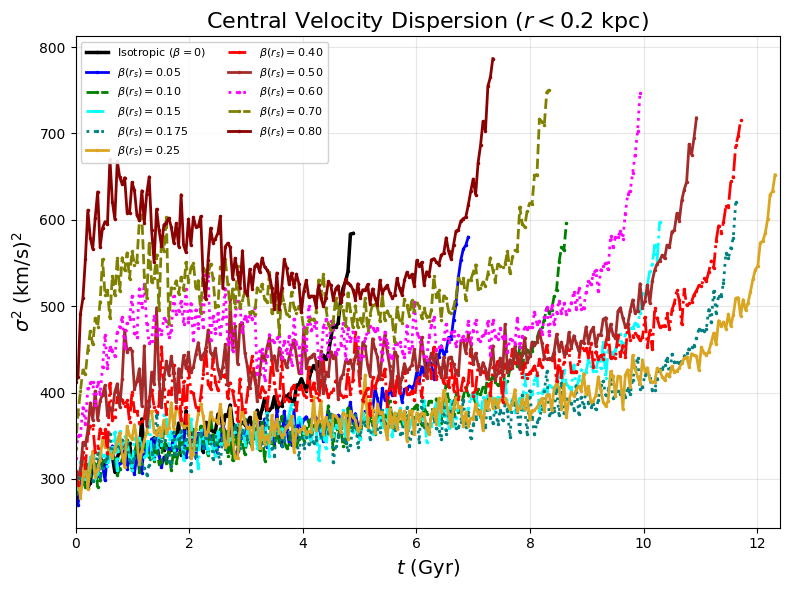

In [7]:
# Figure 3a: Central velocity dispersion evolution for all OM models
# Truncate each curve at its velocity dispersion peak
fig_v2, ax_v2 = plt.subplots(figsize=(8, 6))

for run_label, data in results_om.items():
    if len(data['msv_bins1_n']) > 0:
        # Find velocity dispersion peak for THIS curve
        valid_mask = ~np.isnan(data['msv_bins1_n'])
        if np.any(valid_mask):
            msv_valid = data['msv_bins1_n'][valid_mask]
            time_valid = data['time'][valid_mask]
            
            # Find peak in velocity dispersion
            msv_peak_idx = np.argmax(msv_valid)
            
            # Plot only up to velocity dispersion peak
            ax_v2.plot(time_valid[:msv_peak_idx+1], msv_valid[:msv_peak_idx+1], 
                     marker='.', linestyle=data['linestyle'], color=data['color'], 
                     label=run_label, linewidth=data['linewidth'], markersize=3)

ax_v2.set_xlabel(r"$t$ (Gyr)", fontsize=14)
ax_v2.set_ylabel(r"$\sigma^2$ (km/s)$^2$", fontsize=14)
ax_v2.set_title(r"Central Velocity Dispersion ($r < 0.2$ kpc)", fontsize=16)
ax_v2.legend(fontsize=8, loc='upper left', ncol=2, framealpha=0.9)
ax_v2.set_xlim(0, 12.4)
ax_v2.grid(True, alpha=0.3)
ax_v2.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()

# Save Figure 3a as PDF (matching paper figure)
# This generates pdf/fig3a.pdf - velocity dispersion for 11 Osipkov-Merritt models
# Each curve shows evolution up to its σ² peak (extended runs to 16.2 Gyr where available)
# Comment out the lines below if you only want to view the figure without saving
os.makedirs("pdf", exist_ok=True)
plt.savefig("pdf/fig3a.pdf", dpi=300, bbox_inches='tight')
print('Saved: pdf/fig3a.pdf')

plt.show()

Saved: pdf/fig3b.pdf


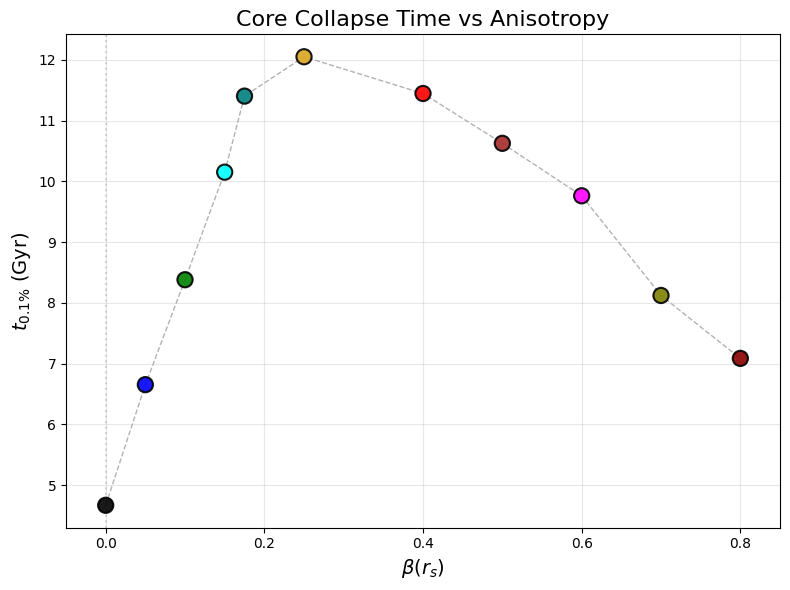

In [8]:
# Figure 3b: Core collapse time vs anisotropy parameter
fig_beta, ax_beta = plt.subplots(figsize=(8, 6))

if om_threshold_data:
    beta_s_values = [d["beta_s"] for d in om_threshold_data]
    t_threshold_values = [d["t_0.1%"] for d in om_threshold_data]
    colors = [d["color"] for d in om_threshold_data]
    
    ax_beta.scatter(beta_s_values, t_threshold_values, c=colors, s=120, zorder=3, 
                edgecolors="black", linewidth=1.5, alpha=0.9)
    ax_beta.plot(beta_s_values, t_threshold_values, "k--", alpha=0.3, linewidth=1, zorder=1)
    
    ax_beta.set_xlabel(r"$\beta(r_s)$", fontsize=14)
    ax_beta.set_ylabel(r"$t_{0.1\%}$ (Gyr)", fontsize=14)
    ax_beta.set_title(r"Core Collapse Time vs Anisotropy", fontsize=16)
    ax_beta.grid(True, alpha=0.3)
    ax_beta.set_xlim(-0.05, max(beta_s_values) + 0.05 if beta_s_values else 0.85)
    ax_beta.axvline(x=0, color="gray", linestyle=":", alpha=0.3)
    ax_beta.tick_params(axis="both", which="major", labelsize=10)

plt.tight_layout()

# Save Figure 3b as PDF (matching paper figure)
# This generates pdf/fig3b.pdf - collapse time (t_0.1%) vs β(r_s) for 11 OM models
# Shows when 100 particles (0.1% threshold) first enter r < 0.02 kpc
# Comment out the lines below if you only want to view the figure without saving
os.makedirs("pdf", exist_ok=True)
plt.savefig("pdf/fig3b.pdf", dpi=300, bbox_inches='tight')
print('Saved: pdf/fig3b.pdf')

plt.show()

## Figure 4: Theoretical Velocity Dispersion Profiles

This cell calculates theoretical velocity dispersion profiles using the Jeans equation. No simulation data required - purely analytical calculations for:
- **Model 1**: Constant β (5 values: -0.5, -0.25, 0, 0.25, 0.5)
- **Model 2**: Osipkov-Merritt with variable β(r) (4 r_a values)

Constants:
  G = 4.302e-06 kpc (km/s)^2 / M_sun
  r_s = 1.18 kpc
  rho_s = 27300000.0 M_sun / kpc^3
Functions defined:
  Model 1 (constant β): v_squared_model1(r, beta)
  Model 2 (OM): v_squared_model2(r, r_a)

Generating velocity dispersion profiles...

Model 1: Computing 5 constant-β profiles...
  β =  0.50: complete
  β =  0.25: complete
  β =  0.00: complete
  β = -0.25: complete
  β = -0.50: complete

Model 2: Computing 4 OM profiles...
  r_a =  0.3r_s: complete
  r_a =  1.0r_s: complete
  r_a =  3.3r_s: complete
  r_a = 10.0r_s: complete

Saved: pdf/fig4.pdf


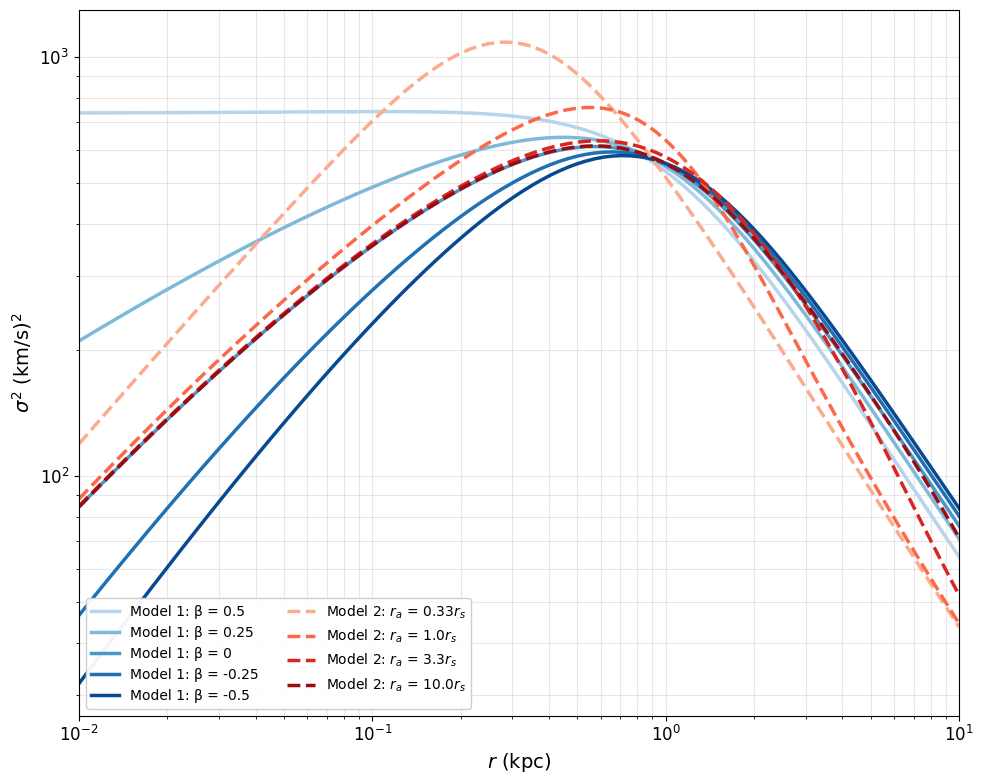

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import matplotlib as mpl

# Set up for publication quality
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['lines.linewidth'] = 2

# Physical constants
G = 4.302e-6  # kpc (km/s)^2 / M_sun
r_s = 1.18  # kpc
rho_s = 2.73e7  # M_sun / kpc^3

print('Constants:')
print(f'  G = {G} kpc (km/s)^2 / M_sun')
print(f'  r_s = {r_s} kpc')
print(f'  rho_s = {rho_s} M_sun / kpc^3')

# Define functions for Hernquist profile
def M(r):
    """Enclosed mass function"""
    return 2 * np.pi * rho_s * r_s**3 * r**2 / (r**2 + r_s**2)

def n(r):
    """Number density function"""
    return 1 / ((r/r_s) * (1 + r/r_s)**3)

# Model 1: Constant beta
def integrand_model1(r_prime, r, beta):
    """Integrand for model 1"""
    return r_prime**(2*beta - 2) * n(r_prime) * M(r_prime)

def v_r_squared_model1(r, beta):
    """Radial velocity dispersion squared for model 1"""
    integral, _ = quad(integrand_model1, r, np.inf, args=(r, beta))
    return G * integral / (r**(2*beta) * n(r))

def v_squared_model1(r, beta):
    """Total velocity dispersion squared for model 1"""
    return v_r_squared_model1(r, beta) * (3 - 2*beta)

# Model 2: Variable beta (Osipkov-Merritt)
def beta_model2(r, r_a):
    """Beta function for model 2"""
    return r**2 / (r**2 + r_a**2)

def integrand_model2(r_prime, r, r_a):
    """Integrand for model 2"""
    return ((r_a/r_prime)**2 + 1) * n(r_prime) * M(r_prime)

def v_r_squared_model2(r, r_a):
    """Radial velocity dispersion squared for model 2"""
    integral, _ = quad(integrand_model2, r, np.inf, args=(r, r_a))
    return G * integral / ((r_a**2 + r**2) * n(r))

def v_squared_model2(r, r_a):
    """Total velocity dispersion squared for model 2"""
    beta_r = beta_model2(r, r_a)
    return v_r_squared_model2(r, r_a) * (3 - 2*beta_r)

print('Functions defined:')
print('  Model 1 (constant β): v_squared_model1(r, beta)')
print('  Model 2 (OM): v_squared_model2(r, r_a)')

# Create the plot
print('\nGenerating velocity dispersion profiles...')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Radius range (in kpc)
r_range = np.logspace(-2, 1, 100)  # 0.01 to 10 kpc

# Model 1: Plot for different beta values
beta_values = [0.5, 0.25, 0, -0.25, -0.5]
colors_model1 = plt.cm.Blues(np.linspace(0.3, 0.9, len(beta_values)))

print(f'\nModel 1: Computing {len(beta_values)} constant-β profiles...')
for beta, color in zip(beta_values, colors_model1):
    v2_values = [v_squared_model1(r, beta) for r in r_range]
    ax.plot(r_range, v2_values, color=color, 
            label=f'Model 1: β = {beta}',
            linestyle='-', linewidth=2.5)
    print(f'  β = {beta:5.2f}: complete')

# Model 2: Plot for different r_a values
r_a_factors = [0.33, 1.0, 3.3, 10.0]
r_a_values = [factor * r_s for factor in r_a_factors]
colors_model2 = plt.cm.Reds(np.linspace(0.3, 0.9, len(r_a_values)))

print(f'\nModel 2: Computing {len(r_a_values)} OM profiles...')
for r_a, factor, color in zip(r_a_values, r_a_factors, colors_model2):
    v2_values = [v_squared_model2(r, r_a) for r in r_range]
    ax.plot(r_range, v2_values, color=color, 
            label=f'Model 2: $r_a$ = {factor}$r_s$',
            linestyle='--', linewidth=2.5)
    print(f'  r_a = {factor:4.1f}r_s: complete')

# Formatting with log-log scale
ax.set_xlabel(r'$r$ (kpc)')
ax.set_ylabel(r'$\sigma^2$ (km/s)$^2$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, which='both')
ax.set_xlim(0.01, 10)

# Create a two-column legend
ax.legend(ncol=2, loc='lower left', framealpha=0.95)

plt.tight_layout()

# Save Figure 4 as PDF (matching paper figure)
# This generates pdf/fig4.pdf - theoretical velocity dispersion profiles from Jeans equation
# Model 1: 5 constant-β profiles (blue solid lines)
# Model 2: 4 Osipkov-Merritt profiles with variable β(r) (red dashed lines)
# Comment out the lines below if you only want to view the figure without saving
os.makedirs("pdf", exist_ok=True)
plt.savefig("pdf/fig4.pdf", dpi=300, bbox_inches='tight')
print('\nSaved: pdf/fig4.pdf')

plt.show()